### XGBoost

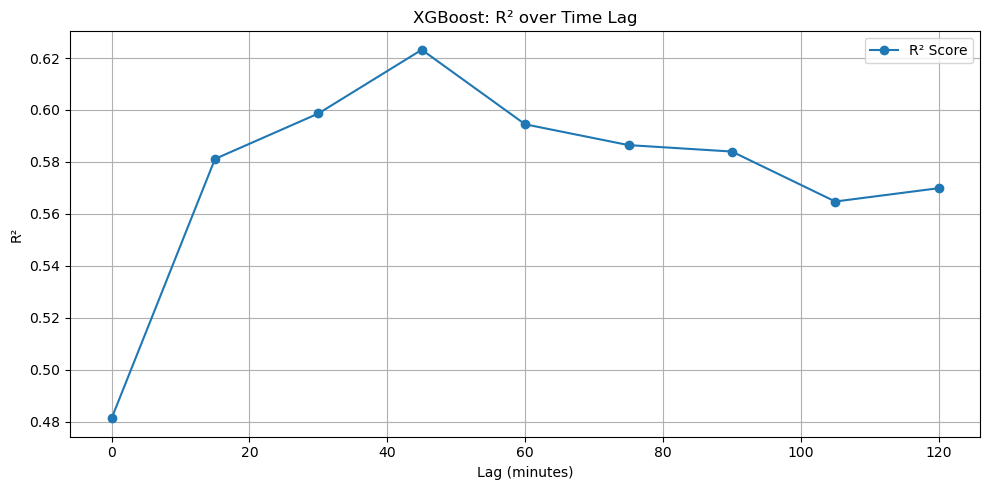

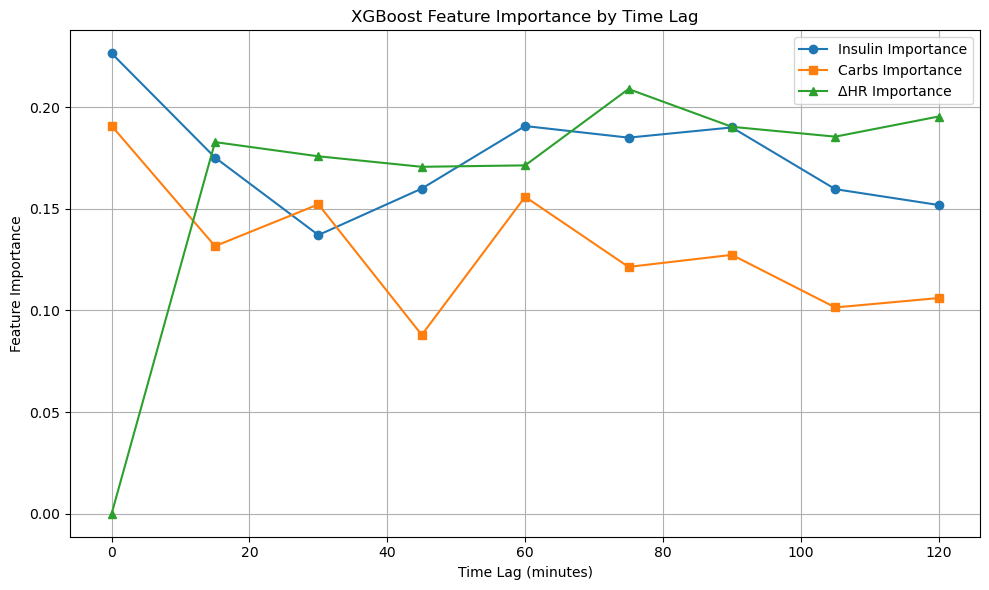


=== XGBoost Regression Summary (with delta_hr) ===

   lag_min  R_squared  insulin_lag_importance  carbs_lag_importance  \
0        0     0.4813                  0.2265                0.1908   
1       15     0.5812                  0.1752                0.1316   
2       30     0.5986                  0.1371                0.1522   
3       45     0.6232                  0.1599                0.0880   
4       60     0.5945                  0.1907                0.1559   
5       75     0.5865                  0.1850                0.1214   
6       90     0.5840                  0.1900                0.1273   
7      105     0.5647                  0.1596                0.1015   
8      120     0.5699                  0.1519                0.1061   

   steps_lag_importance  cals_lag_importance  delta_hr_importance  \
0                0.2008               0.2406               0.0000   
1                0.1917               0.1808               0.1828   
2                0.1670      

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/proc/sep/by_patient/p01.csv')

# Min-Max Scaling
scale_cols = ["insulin", "carbs", "steps", "cals", "hr", "bg"]  # ✅ hr 추가
scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

# bg 변화량 계산
df["bg_diff"] = df["bg"].diff()

# 결과 저장
results = []

# lag 반복 (0~8: 0~120분)
for lag in range(0, 9):
    df_lagged = df.copy()
    
    for col in ["insulin", "carbs", "steps", "cals", "hr"]:
        df_lagged[f"{col}_lag"] = df_lagged[col].shift(lag)

    # delta_hr 계산
    df_lagged["delta_hr"] = df_lagged["hr"] - df_lagged["hr_lag"]

    # 교호작용 항
    df_lagged["insulin_x_carbs_lag"] = df_lagged["insulin_lag"] * df_lagged["carbs_lag"]

    # 모델 입력 준비
    predictors = ["insulin_lag", "carbs_lag", "steps_lag", "cals_lag", "delta_hr", "insulin_x_carbs_lag"]
    df_model = df_lagged[["bg_diff"] + predictors].dropna()

    if df_model.empty:
        continue

    X = df_model[predictors]
    y = df_model["bg_diff"]

    # XGBoost 모델 학습
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
    model.fit(X, y)

    # 예측 및 R² 계산
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    # 중요도 추출
    feature_importances = model.feature_importances_
    results.append({
        "lag_min": lag * 15,
        "R_squared": r2,
        **{f"{feat}_importance": imp for feat, imp in zip(predictors, feature_importances)}
    })

# 결과 정리
results_df = pd.DataFrame(results)

# 📊 시각화: R²
plt.figure(figsize=(10, 5))
plt.plot(results_df["lag_min"], results_df["R_squared"], marker='o', label="R² Score")
plt.title("XGBoost: R² over Time Lag")
plt.xlabel("Lag (minutes)")
plt.ylabel("R²")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# 📊 시각화: 주요 Feature Importance 변화
plt.figure(figsize=(10, 6))
plt.plot(results_df["lag_min"], results_df["insulin_lag_importance"], marker='o', label='Insulin Importance')
plt.plot(results_df["lag_min"], results_df["carbs_lag_importance"], marker='s', label='Carbs Importance')
plt.plot(results_df["lag_min"], results_df["delta_hr_importance"], marker='^', label='ΔHR Importance')
plt.title("XGBoost Feature Importance by Time Lag")
plt.xlabel("Time Lag (minutes)")
plt.ylabel("Feature Importance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📃 결과 출력
print("\n=== XGBoost Regression Summary (with delta_hr) ===\n")
print(results_df.round(4))

### ODE model: SinDy

In [43]:
import pandas as pd
import numpy as np
from pysindy import SINDy
from sklearn.preprocessing import MinMaxScaler
from pysindy.differentiation import FiniteDifference
from pysindy.optimizers import STLSQ

# 1. 데이터 로드 및 전처리
df = pd.read_csv("/Users/jaehwayang/DSL/EDA/proc/sep/by_patient/p01.csv")
variables = ['bg', 'insulin', 'carbs', 'hr', 'steps', 'cals']
df = df[variables].dropna()

# 2. 정규화
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# 3. 시간 간격 설정
dt = 15 * 60  # 15분 간격 → 초 단위

# 4. 모델 정의 및 학습
model = SINDy(
    differentiation_method=FiniteDifference(order=1),
    optimizer=STLSQ(threshold=0.001)
)
model.fit(df_scaled, t=dt)
model.print()

(x0)' = 0.000
(x1)' = -0.001 x1 + 0.001 x2 + -0.002 x1 x2
(x2)' = 0.000
(x3)' = 0.000
(x4)' = 0.000
(x5)' = 0.000


/Users/jaehwayang/miniconda3/envs/basic/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(
/Users/jaehwayang/miniconda3/envs/basic/lib/python3.11/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(


In [30]:
import pandas as pd
import numpy as np
from pysindy import SINDy
from pysindy.differentiation import FiniteDifference
from pysindy.optimizers import STLSQ
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 로드 및 전처리
df = pd.read_csv('/Users/jaehwayang/DSL/EDA/proc/CGM1.csv')
df = df[['CGM', 'BasalRate', 'CarbAmount']].dropna()

# 2. 정규화
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# 3. 시간 간격 설정 (15분 = 900초)
dt = 300

# 4. 입력 데이터 정의
X = df_scaled  # [CGM, BasalRate, CarbAmount]

# 5. SINDy 모델 정의 (target: CGM)
model = SINDy(
    optimizer=STLSQ(threshold=0.001),
    differentiation_method=FiniteDifference(order=1),
    feature_names=["CGM", "BasalRate", "CarbAmount"]
)

# 6. 학습 및 결과 출력
model.fit(x=X, t=dt)
model.print()

(CGM)' = 0.019 CarbAmount + -0.044 CGM CarbAmount + -0.014 BasalRate CarbAmount
(BasalRate)' = -0.001 BasalRate + 0.006 CGM CarbAmount + -0.014 BasalRate CarbAmount
(CarbAmount)' = -0.002 CarbAmount + 0.004 BasalRate CarbAmount


In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pysindy import SINDy
from pysindy.differentiation import FiniteDifference
from pysindy.optimizers import STLSQ
from pysindy.feature_library import PolynomialLibrary

# 데이터 로드 및 전처리
df = pd.read_csv("/Users/jaehwayang/DSL/EDA/proc/CGM1.csv")
df = df[["CGM", "BasalRate", "CarbAmount"]].dropna()

# 정규화
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
cgm_scaled = df_scaled[:, 0].reshape(-1, 1)         # 종속 변수 y
controls_scaled = df_scaled[:, 1:]                  # 제어 입력 u

# 시간 간격 설정 (15분 → 초 단위)
dt = 5 * 60

# SINDy with control 구성
model = SINDy(
    differentiation_method=FiniteDifference(order=4),
    optimizer=STLSQ(threshold=0.001),
    feature_library=PolynomialLibrary(degree=2, include_interaction=True),
    feature_names=['CGM', 'BasalRate', 'CarbAmount'],
    discrete_time=False
)

# 모델 학습
model.fit(x=cgm_scaled, u=controls_scaled, t=dt)

# 모델 출력
model.print()

(CGM)' = -0.006 CGM CarbAmount + 0.017 BasalRate CarbAmount + 0.002 CarbAmount^2


### 미분방정식 기반 시뮬레이션과 실제 데이터 이동평균 비교

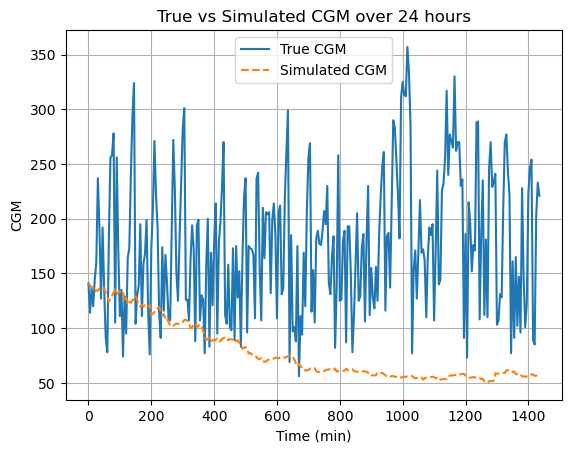

in MA]  MAE=98.07, RMSE=106.49, R2=-22.037


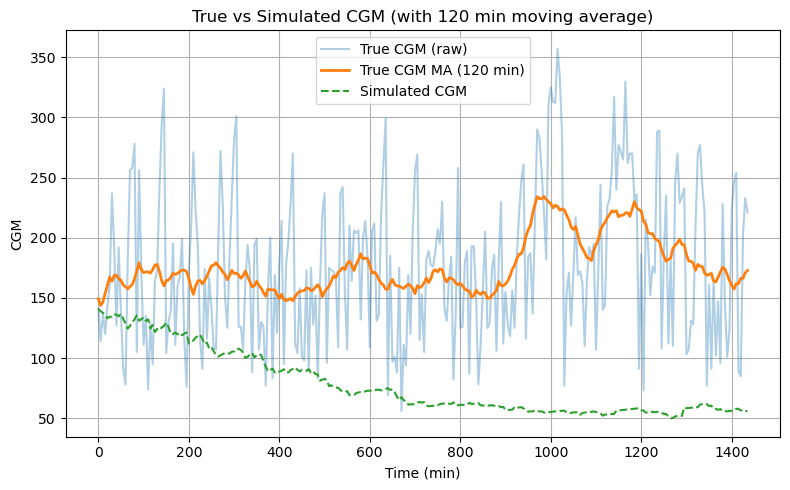

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
df = pd.read_csv("/Users/jaehwayang/DSL/EDA/proc/CGM1.csv")[["CGM", "BasalRate", "CarbAmount"]].dropna()

# 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
CGM_full, BR_full, CA_full = scaled[:, 0], scaled[:, 1], scaled[:, 2]   # NEW: 전체 보관

# 시간 설정
dt = 300  # CHANGED: 실제 간격이 15분이면 900으로 바꾸세요 (현재는 300초=5분)
# 24시간에 해당하는 샘플 개수
n_24h = int(24 * 3600 / dt)                                             # NEW
n_24h = min(n_24h, len(CGM_full))                                       # NEW: 데이터 길이보다 길 경우 보정

# 24시간 구간만 사용
CGM = CGM_full[:n_24h]                                                  # NEW
BR  = BR_full[:n_24h]                                                   # NEW
CA  = CA_full[:n_24h]                                                   # NEW

t = np.arange(len(CGM)) * dt                                            # CHANGED: 24시간 길이에 맞춰 재생성

# (CGM)' = -0.004 CGM CarbAmount + 0.013 BasalRate CarbAmount + 0.002 CarbAmount^2
# 미분방정식
def dCGM_dt(cgm, t_idx):
    # t_idx는 실제 시간(초), dt는 샘플 간격(초)
    idx = int(t_idx / dt)
    idx = max(0, min(idx, len(CA) - 1))  # 경계 보정

    br = BR[idx]
    ca = CA[idx]

    return (
        0.003 * cgm * br
        - 0.007 * cgm * ca
        - 0.003 * br**2
        + 0.013 * br * ca
        - 0.003 * (cgm**2) * br
        + 0.024 * cgm * br * ca
        + 0.005 * cgm * (ca**2)
        + 0.003 * br**3
        - 0.033 * (br**2) * ca
    )

# 시뮬레이션
CGM0 = CGM[0]
sim_cgm = odeint(lambda y, t: dCGM_dt(y, t), CGM0, t).flatten()

# 역정규화 (BR, CA도 같은 24시간 구간으로 스택)
rescaled = scaler.inverse_transform(np.column_stack([sim_cgm, BR, CA]))  # CHANGED
sim_cgm_rescaled = rescaled[:, 0]
true_cgm = df["CGM"].values[:n_24h]                                      # NEW: 실제 값도 24시간으로 제한

# 시각화 (x축: 분)
plt.plot(t / 60, true_cgm, label="True CGM")
plt.plot(t / 60, sim_cgm_rescaled, label="Simulated CGM", linestyle="--")
plt.xlabel("Time (min)")
plt.ylabel("CGM")
plt.title("True vs Simulated CGM over 24 hours")
plt.legend()
plt.grid()
plt.show()

# ... (위에서 시뮬레이션까지 동일) ...

# ----------------------------
# 이동평균으로 True CGM 평활
# ----------------------------
window_minutes = 120                       # ← 원하시는 창 크기(분)로 조절
window_samples = max(1, int(round(window_minutes * 60 / dt)))

true_cgm_ma = (
    pd.Series(true_cgm)
    .rolling(window=window_samples, center=True, min_periods=1)
    .mean()
    .values
)

# ----------------------------
# 오차 지표(선택)
# ----------------------------
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae  = mean_absolute_error(true_cgm_ma, sim_cgm_rescaled)
rmse = np.sqrt(mean_squared_error(true_cgm_ma, sim_cgm_rescaled))
r2   = r2_score(true_cgm_ma, sim_cgm_rescaled)
print(f"[{window_minutes}min MA]  MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.3f}")

# ----------------------------
# 시각화
# ----------------------------
plt.figure(figsize=(8,5))
plt.plot(t/60, true_cgm,          label="True CGM (raw)", alpha=0.35)
plt.plot(t/60, true_cgm_ma,       label=f"True CGM MA ({window_minutes} min)", linewidth=2)
plt.plot(t/60, sim_cgm_rescaled,  label="Simulated CGM", linestyle="--")
plt.xlabel("Time (min)")
plt.ylabel("CGM")
plt.title(f"True vs Simulated CGM (with {window_minutes} min moving average)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()